In [1]:
# 1: Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

try:
    # Set TensorFlow version to 2.x if running on Google Colab
    %tensorflow_version 2.x
except Exception:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# 2: Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/c

In [3]:
# 3: Create image generators
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

dummy_subdir = os.path.join(test_dir, 'dummy')

os.makedirs(dummy_subdir, exist_ok=True)

for filename in os.listdir(test_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.move(os.path.join(test_dir, filename), os.path.join(dummy_subdir, filename))

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


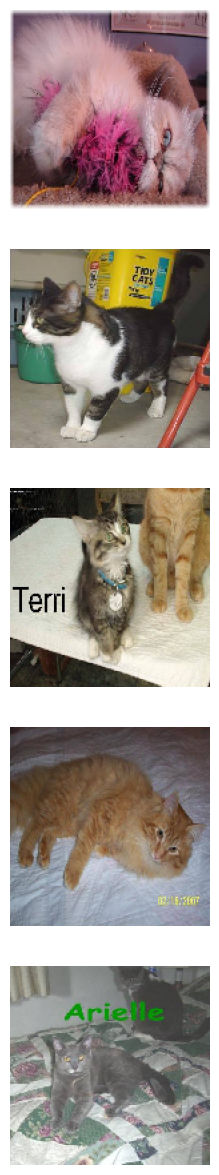

In [4]:
# 4: Define function for plotting images
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# Example
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [5]:
# 5: Define transformations to create more training data (fix overfitting)
train_image_generator = ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0, 1], grey scale
    rotation_range=10,                # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,            # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,           # Randomly shift images vertically by up to 10%
    shear_range=0.1,                  # Shear transformations (tilt the image)
    zoom_range=0.1,                   # Randomly zoom in or out by up to 10%
    horizontal_flip=True,             # Randomly flip images horizontally
    fill_mode='nearest'               # Fill in any empty pixels after transformations
)

Found 2000 images belonging to 2 classes.


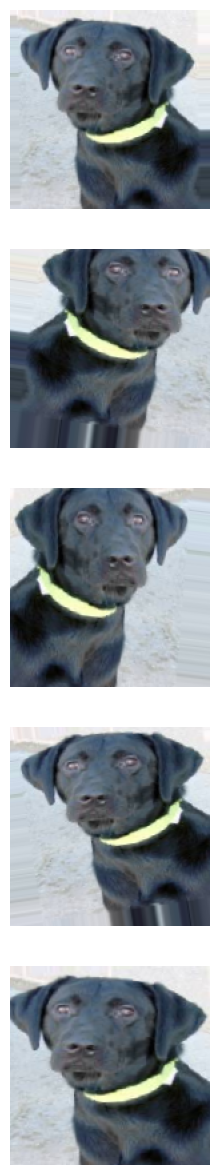

In [6]:
# 6: Visualize image variations
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7: Create the convolutional neural network (CNN)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8: Train the model
history = model.fit(
    train_data_gen,               # The training data generator
    steps_per_epoch=total_train // batch_size,  # Number of steps per epoch
    epochs=epochs,                # Total number of epochs to train
    validation_data=val_data_gen, # The validation data generator
    validation_steps=total_val // batch_size  # Number of validation steps per epoch
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - accuracy: 0.5034 - loss: 1.4913 - val_accuracy: 0.5045 - val_loss: 0.6914
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - accuracy: 0.4766 - loss: 0.6969

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4766 - loss: 0.6969 - val_accuracy: 0.5011 - val_loss: 0.6916
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 179s 8s/step - accuracy: 0.5137 - loss: 0.6920 - val_accuracy: 0.5089 - val_loss: 0.6827
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4766 - loss: 0.6897 - val_accuracy: 0.5045 - val_loss: 0.6854
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.5175 - loss: 0.6873 - val_accuracy: 0.6518 - val_loss: 0.6792
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6250 - loss: 0.6856 - val_accuracy: 0.6138 - val_loss: 0.6764
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.6052 - loss: 0.6753 - val_accuracy: 0.6295 - val_loss: 0.6357
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7266 - loss: 0.6320 - val_accuracy: 0.5112 - val_loss: 0.7088
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step - accuracy: 0.6168 - loss: 0.6526 - val_accuracy: 0.6551 - val_loss: 0.620

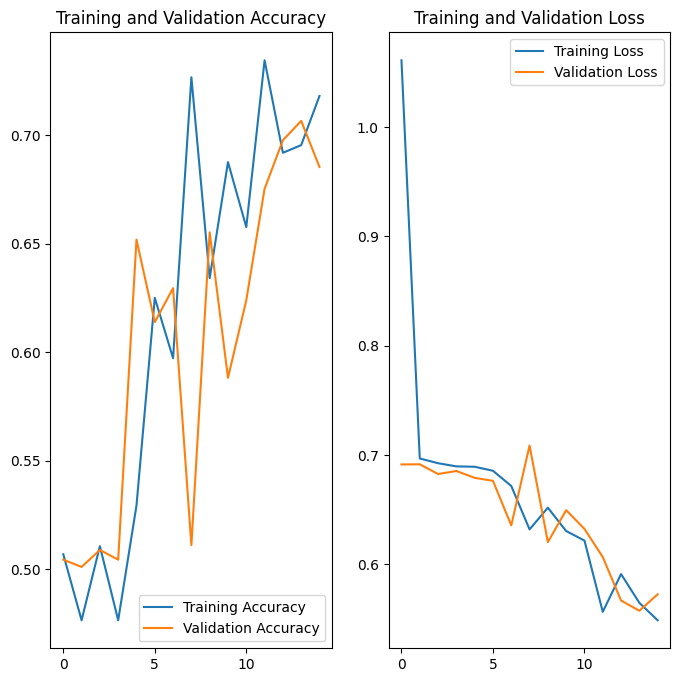

In [9]:
# 9: Visualize the accuracy and loss of the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


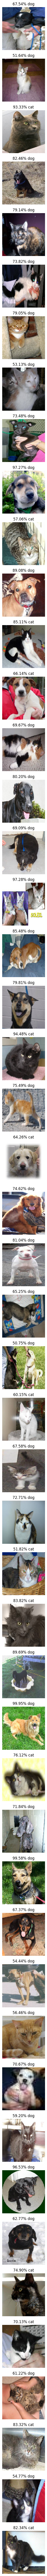

In [10]:
# 10: Test predictions
predictions = model.predict(test_data_gen, steps=total_test // batch_size, verbose=1)

probabilities = np.array(predictions).flatten()

test_images = next(test_data_gen)

plotImages(test_images, probabilities)

In [11]:
# 11: Test the model performance
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
